# Прогнозирование продаж товара

В нашем распоряжении имеется база данных некоторого сетевого супермаркета Х. 

**Задача:**
- Выполнить необходимые SQL запросы к базе данных
- Провести анализ данных
- Спрогнозировать продажи товара 7d185936-7a60-11eb-ba7f-4a6a34607ded на следующую неделю

In [1]:
from clickhouse_driver import Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import re
import warnings
warnings.filterwarnings('ignore')

## 1. Анализ данных

Для начала посмотрим, какие данные есть в базе данных. Выведем небольшой кусок каждой таблицы.

In [2]:
client = Client(host='82.148.25.91',
user='ro_test',
password='qwerty',
database='test')

In [3]:
client.execute('SHOW DATABASES')

[('test',)]

In [4]:
client.execute('SHOW TABLES')

[('brands',),
 ('products',),
 ('sales',),
 ('stocks_items',),
 ('stocks_on_days',),
 ('warehouse',)]

In [5]:
def read_sql(sql):
    data, columns = client.execute(sql, columnar=True, with_column_types=True)
    df = pd.DataFrame({re.sub(r'\W', '_', col[0]): d for d, col in zip(data, columns)})

    return df

In [6]:
tables = ['brands', 'products', 'sales', 'stocks_items', 'stocks_on_days', 'warehouse']

In [7]:
for t in tables:
    exec(f"{t} = read_sql(f'SELECT * FROM test.{t} LIMIT 100')")

In [8]:
datasets = [brands, products, sales, stocks_items, stocks_on_days, warehouse]

In [9]:
for i in range(len(datasets)):
    print(tables[i])
    display(datasets[i].head())

brands


,id
0,e4bb9416-7a5e-11eb-ba7f-4a6a34607ded
1,a2c5d2e6-815e-11eb-ba83-4a6a34607ded
2,d791ff9b-e289-11eb-ba8e-4a6a34607ded
3,e3b371b0-e289-11eb-ba8e-4a6a34607ded
4,564a2208-3b3e-11ec-ba95-4a6a34607ded


products


,item_id,brand_id,name
0,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,a2c5d32e-815e-11eb-ba83-4a6a34607ded,
1,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,a2c5d3a5-815e-11eb-ba83-4a6a34607ded,
2,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,a2c5d3a5-815e-11eb-ba83-4a6a34607ded,
3,6b2f433a-7a60-11eb-ba7f-4a6a34607ded,2cc0cde0-7a5e-11eb-ba7f-4a6a34607ded,
4,6b2f433b-7a60-11eb-ba7f-4a6a34607ded,a2c5d3a5-815e-11eb-ba83-4a6a34607ded,


sales


,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
0,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,18182038263494297277,0,1,48.99,28.97
1,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433b-7a60-11eb-ba7f-4a6a34607ded,3067269784031516499,0,2,153.98,51.51
2,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433d-7a60-11eb-ba7f-4a6a34607ded,3858903404745967994,0,1,74.99,55
3,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433e-7a60-11eb-ba7f-4a6a34607ded,12419429600051941021,0,2,169.58,66
4,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4340-7a60-11eb-ba7f-4a6a34607ded,11509266293066022547,0,1,43.89,41.3


stocks_items


,stock_id,item_id,quantity
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,7
1,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,19
2,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,4
3,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433a-7a60-11eb-ba7f-4a6a34607ded,1
4,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433b-7a60-11eb-ba7f-4a6a34607ded,48


stocks_on_days


,date,stock_id,item_id,start_day,finish_day
0,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4337-7a60-11eb-ba7f-4a6a34607ded,8,8
1,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4338-7a60-11eb-ba7f-4a6a34607ded,40,39
2,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f4339-7a60-11eb-ba7f-4a6a34607ded,15,15
3,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433a-7a60-11eb-ba7f-4a6a34607ded,1,1
4,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,6b2f433b-7a60-11eb-ba7f-4a6a34607ded,24,22


warehouse


,id,name
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,31
1,126055b5-2c17-11ec-ba94-8141c2516b9e,29
2,708b9941-3c6f-11ec-ba95-4a6a34607ded,30
3,bb818041-3c6f-11ec-ba95-4a6a34607ded,36
4,e1627618-3c6f-11ec-ba95-4a6a34607ded,32


1. *brands* - таблица нам не понадобится, в ней просто перечислены имеющиеся бренды.
2. *products* - таблица содержит имеющиеся продукты с указанием брендов. Если бы мы знали наименования товаров или их тип (молоко, макароны и т.д.), то можно было бы использовать в анализе данные по всем таким же товарам других брендов. Но мы не знаем тип товаров, поэтому данная таблица нам не понадобится.
3. *sales* - таблица содержит следующие столбцы:
    - дата
    - id магазина
    - id товара
    - номер заказа
    - цену товара (в этом столбце почему-то много нулей)
    - количество проданых единиц товара
    - суммарная стоимость проданого товара
    - непонятный столбец sebes
    
    
4. *stocks_items* - id магазинов в этой таблице совпадают с предыдущей, хоть столбцы и называются по разному. Позже мы проверим, что совпадают все магазины. Также в этой таблице приведено количество каждого товара, правда не очень понятно, к чему это количество относится.
5. *stocks_on_days* - здесь содержатся данные по дням о наличии товара в магазине в начале и конце дня.
6. *warehouse* - таблица содержит имена магазинов.

Проверим, что магазины в таблицах *sales* и *stocks_on_days* совпадают. Проверку выполним сразу только для необходимого товара

In [10]:
stocks = read_sql('''
SELECT 
    DISTINCT(stock_id)
FROM 
    test.stocks_on_days 
WHERE 
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded';
''').join(read_sql('''
SELECT 
    DISTINCT(warehouse_id)
FROM 
    test.sales 
WHERE 
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded';    
    '''))
stocks['stock_id_has_pair'] = np.zeros(len(stocks))
display(stocks)

,stock_id,warehouse_id,stock_id_has_pair
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,01ffab2c-3c70-11ec-ba95-4a6a34607ded,0.0
1,126055b5-2c17-11ec-ba94-8141c2516b9e,bb818041-3c6f-11ec-ba95-4a6a34607ded,0.0
2,708b9941-3c6f-11ec-ba95-4a6a34607ded,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,0.0
3,01ffab2c-3c70-11ec-ba95-4a6a34607ded,4787ce96-7a69-11eb-ba7f-4a6a34607ded,0.0
4,bb818041-3c6f-11ec-ba95-4a6a34607ded,0ad8892d-3c70-11ec-ba95-4a6a34607ded,0.0
5,e1627618-3c6f-11ec-ba95-4a6a34607ded,d24bc91d-50f4-11ec-ba96-4a6a34607ded,0.0
6,d24bc91d-50f4-11ec-ba96-4a6a34607ded,e523eaae-50f4-11ec-ba96-4a6a34607ded,0.0
7,e523eaae-50f4-11ec-ba96-4a6a34607ded,ed86c36a-50f4-11ec-ba96-4a6a34607ded,0.0
8,ed86c36a-50f4-11ec-ba96-4a6a34607ded,126055b5-2c17-11ec-ba94-8141c2516b9e,0.0
9,f6e80261-3c6f-11ec-ba95-4a6a34607ded,f6e80261-3c6f-11ec-ba95-4a6a34607ded,0.0


Количество магазинов одинаковое, проверим все ли они совпадают

In [11]:
for stock in stocks['stock_id']:
    for i in range(len(stocks)):
        if stock == stocks['warehouse_id'][i]:
            stocks['stock_id_has_pair'] = 1
display(stocks)

,stock_id,warehouse_id,stock_id_has_pair
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,01ffab2c-3c70-11ec-ba95-4a6a34607ded,1
1,126055b5-2c17-11ec-ba94-8141c2516b9e,bb818041-3c6f-11ec-ba95-4a6a34607ded,1
2,708b9941-3c6f-11ec-ba95-4a6a34607ded,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,1
3,01ffab2c-3c70-11ec-ba95-4a6a34607ded,4787ce96-7a69-11eb-ba7f-4a6a34607ded,1
4,bb818041-3c6f-11ec-ba95-4a6a34607ded,0ad8892d-3c70-11ec-ba95-4a6a34607ded,1
5,e1627618-3c6f-11ec-ba95-4a6a34607ded,d24bc91d-50f4-11ec-ba96-4a6a34607ded,1
6,d24bc91d-50f4-11ec-ba96-4a6a34607ded,e523eaae-50f4-11ec-ba96-4a6a34607ded,1
7,e523eaae-50f4-11ec-ba96-4a6a34607ded,ed86c36a-50f4-11ec-ba96-4a6a34607ded,1
8,ed86c36a-50f4-11ec-ba96-4a6a34607ded,126055b5-2c17-11ec-ba94-8141c2516b9e,1
9,f6e80261-3c6f-11ec-ba95-4a6a34607ded,f6e80261-3c6f-11ec-ba95-4a6a34607ded,1


Все названия магазинов одинаковые, значит в таблицах *stocks_items* и *stocks_on_days* приведена информация по магазинам из столбца *warehouse_id* таблицы *sales*

Разберемся, что за количество товаров представлено в таблице *stocks_items*. Вероятно это количество товаров в магазинах "сейчас", т.е. на момент сбора последних данных. Проверим это. Выгрузим данные таблиц *sales*, *stocks_items* и *stocks_on_days* только для нашего товара и посмотрим их последние данные.

In [12]:
sales_req_item = read_sql('''
SELECT
    *
FROM
    test.sales
WHERE
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded';
''')
display(sales_req_item.tail())

,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
7876,2021-12-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,7877406613501665458,72.89,1,72.89,62
7877,2021-12-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,11923284422298496277,72.89,1,72.89,62
7878,2021-12-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,13810575993281346903,72.89,1,72.89,62
7879,2021-12-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3279305224430219601,72.89,1,72.89,62
7880,2021-12-30,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,5920944686903560122,72.89,1,72.89,62


In [13]:
stocks_items_req_item = read_sql('''
SELECT
    *
FROM
    test.stocks_items
WHERE
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded';
''')
display(stocks_items_req_item)

,stock_id,item_id,quantity
0,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15
1,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,2
2,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3
3,708b9941-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6
4,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1
5,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,5
6,f6e80261-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2
7,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2
8,e523eaae-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6
9,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6


In [14]:
stocks_on_days_req_item = read_sql('''
SELECT
    *
FROM
    test.stocks_on_days
WHERE
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded';
''')
display(stocks_on_days_req_item.tail(15))

,date,stock_id,item_id,start_day,finish_day
4245,2022-01-08,e1627618-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,5,5
4246,2022-01-08,f6e80261-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2,-2
4247,2022-01-08,d24bc91d-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,-2,-2
4248,2022-01-08,e523eaae-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6,6
4249,2022-01-08,ed86c36a-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6,6
4250,2022-01-09,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15,15
4251,2022-01-09,126055b5-2c17-11ec-ba94-8141c2516b9e,7d185936-7a60-11eb-ba7f-4a6a34607ded,2,2
4252,2022-01-09,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3,3
4253,2022-01-09,708b9941-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,6,6
4254,2022-01-09,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1,1


Значения *quantity* в таблице *stocks_items* полностью совпадают со значениями последнего дня в таблице *stocks_on_days*, значит таблица *stocks_items* нам больше не пригодится

Так же стоит отметить, что дата последней информации по продажам не совпадает с датой последней информации по наличию товара. Проверим дату первой информации о наличии и о продажах.

In [15]:
display(stocks_on_days_req_item.head())
display(sales_req_item.head())

,date,stock_id,item_id,start_day,finish_day
0,2020-08-26,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,0
1,2020-08-27,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,0
2,2020-08-28,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,0
3,2020-08-29,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,0
4,2020-08-30,4787ce96-7a69-11eb-ba7f-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,0,0


,date,warehouse_id,item_id,order_number,price,quantity,amount,sebes
0,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,3547355649947603906,0,1,59.99,53.5
1,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,4908248033917346488,0,1,59.99,53.5
2,2021-01-04,01ffab2c-3c70-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,1134184689814738432,0,1,59.99,53.5
3,2021-01-04,bb818041-3c6f-11ec-ba95-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,765388806314934293,0,1,59.99,53.5
4,2021-01-04,d91c6b6b-50f4-11ec-ba96-4a6a34607ded,7d185936-7a60-11eb-ba7f-4a6a34607ded,15616877688297015768,59.99,1,59.99,53.5


Начальная дата тоже не совпадает. В дальнейшем будем фильтровать информацию по датам продаж

Столбцы *price*, *amount* и *sebes* нас в дальнейшем анализе интересовать не будут, потому что это почти константные величины и они не оказывают влияния на количество продаж.

Проанализируем данные о наличии товара в магазинах. Соберем в одну таблицу:
 - разность наличия товара утром и вечером для каждого дня в каждом магазине
 - суммарные продажи за каждый день в каждом магазине
 
Посмотрим, как соотносятся эти величины. Магазины, для наглядности, отобразим их именами, а не id.

In [16]:
a = read_sql('''
SELECT
    table1.date AS date,
    warehouse.name AS stock_name,
    table1.quantity_difference AS quantity_difference,
    table2.stock_sales AS stock_sales
FROM (
    SELECT
        date,
        warehouse_id AS stock_id,
        MIN(item_id),
        SUM(quantity) AS stock_sales
    FROM
        test.sales
    WHERE
        item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
    GROUP BY
        date,
        stock_id
    ORDER BY
        date) AS table2
    RIGHT JOIN (
    SELECT
        *,
        start_day - finish_day AS quantity_difference
    FROM 
        test.stocks_on_days
    WHERE
        item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded'
        AND date <= '2021-12-30'
        AND date >= '2021-01-04') AS table1 ON table1.date = table2.date AND table1.stock_id = table2.stock_id
    LEFT JOIN test.warehouse ON warehouse.id = table1.stock_id
ORDER BY
    date;
''')

In [17]:
display(a.sample(30))

,date,stock_name,quantity_difference,stock_sales
2672,2021-09-15,31,0,0
3251,2021-11-14,29,2,2
2908,2021-10-09,29,0,0
3399,2021-12-01,10,-12,0
1749,2021-06-25,29,1,1
1457,2021-05-30,10,2,2
1733,2021-06-24,11,-3,5
3022,2021-10-21,36,0,0
184,2021-01-23,31,4,13
1209,2021-05-07,36,1,1


Есть дни, в которые количество товара в магазине не изменилось, при этом продажи в этот день были. Есть дни, когда количество товара увеличилось. Можно было бы посчитать поставки товара как разницу продаж и делты товаров в магазине, но есть ещё другие особенности в данных. Есть дни, когда продаж было меньше, чем количество убывшего товара. Так же в данных выше можно заметить странные значения - отрицательные величины наличия товара.

**Вывод**: информации по наличию товара явно недостаточно. 

Таким образом, для дальнейшей работы будем использовать только суммарное ежедневное количество продаж необходимого товара

Получим необходимую таблицу - временной ряд продаж

In [18]:
df = read_sql('''
SELECT 
    date,  
    SUM(quantity) AS day_sales 
FROM 
    test.sales 
WHERE 
    item_id = '7d185936-7a60-11eb-ba7f-4a6a34607ded' 
GROUP BY
    date
ORDER BY
    date
''')

In [19]:
df = df.set_index('date')
df['day_sales']=df['day_sales'].astype(int)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2021-01-04 to 2021-12-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   day_sales  353 non-null    int32
dtypes: int32(1)
memory usage: 4.1 KB


## 2. Прогнозирование продаж на следующую неделю

Построим график и гистограмму по нашим данным.

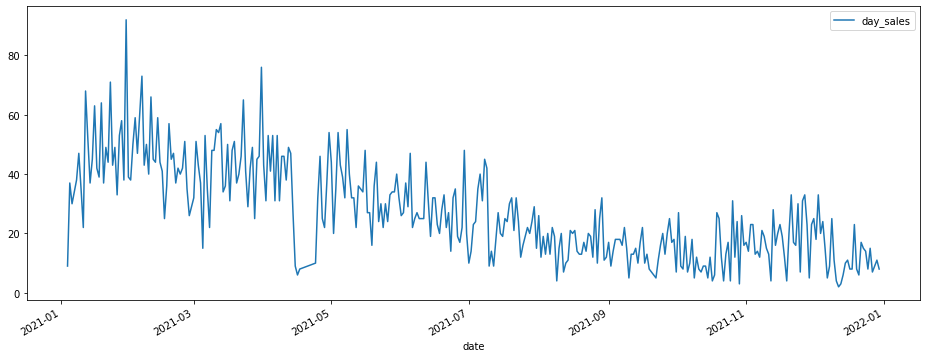

In [21]:
df.plot(figsize=(16,6))
plt.show()

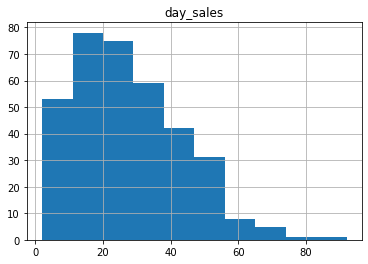

In [22]:
df.hist()
plt.show()

В данном ряду наблюдаются тренд и сезонность. Распределение похоже на распределение Пуассона, которое свойственно для числа событий в единицу времени.

Предсказывать будущие значения будем при помощи линейной регрессии.

**Создание признаков**

Выделим отдельно тренд и сезонность данных, сезонность посмотрим на примере одного случайного месяца.

In [23]:
df = df.resample('1D').sum()
df_decomposed = seasonal_decompose(df['day_sales'])

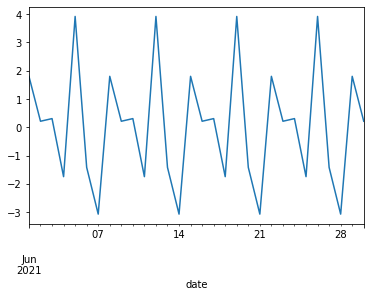

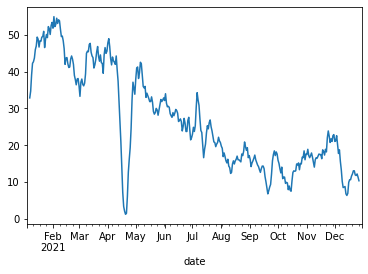

In [24]:
df_decomposed.seasonal['2021-06-01': '2021-06-30'].plot()
plt.show()

df_decomposed.trend.plot()
plt.show()

Есть явная недельная сезонность, поэтому добавим в качестве признаков день недели и является ли день выходным.

Так же есть явный тренд - снижение количества продаж со временем. Добавим в качестве признаков лаги, начиная с седьмого, т.к. нам необходимо предсказывать данные на 7 дней вперед. И добавим скользящее среднее как признак.

Предварительно добавим в ряд даты, для которых необходимо выполнить предсказания, чтобы можно было задать признаки тестовых данных

In [25]:
test = stocks_on_days_req_item.groupby('date').sum().drop('finish_day', axis=1).query("date > '2021-12-30' & date < '2022-01-07'")
test.columns = (['day_sales'])
test['day_sales'] = 0
df=df.append(test)

In [26]:
def make_features(data, max_lag, rolling_mean_size):

    for i in range(7, max_lag):
        data['lag_{}'.format(i)] = data.day_sales.shift(i)

    data['day'] = data.index.day
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    data['mean'] = data.day_sales.shift(7).rolling(rolling_mean_size).mean()

    data = data.dropna()
    data = data.reset_index(drop=True)
    return data

In [27]:
df = make_features(df, 30, 14,)

Напишем 2 функции, которые будут принимать датасет и размеры тестовой и валидационной выборок в днях. Одну для самопроверки, которая делит выборку на тренировочную и валидационную, а тестовый кусок просто отбрасывает, т.к. у нас нет данных по целевому признаку для тестовых дат. Вторую для получения итоговых результатов, она будет делить выборку на тренировочную и тестовую, где в качестве тренировочной будет выступать весь датасет, для которого известен целевой признак.

In [28]:
def data_valid_split(data, valid_size, test_size):
    test_index = len(data) - test_size
    valid_index = test_index - valid_size
    
    X_train = data.loc[:valid_index].drop(["day_sales"], axis=1)
    y_train = data.loc[:valid_index]["day_sales"]
    X_valid = data.loc[valid_index : test_index].drop(["day_sales"], axis=1)
    y_valid = data.loc[valid_index : test_index]["day_sales"]
    
    return X_train, X_valid, y_train, y_valid

def data_test_split(data, test_size):
    test_index = len(data) - test_size
    
    X_train = data.loc[:test_index].drop(["day_sales"], axis=1)
    y_train = data.loc[:test_index]["day_sales"]
    X_test = data.loc[test_index:].drop(["day_sales"], axis=1)
    
    return X_train, X_test, y_train

In [29]:
X_train, X_valid, y_train, y_valid = data_valid_split(df, 30, 7)

Обучим модель линейной регрессии, выполним предсказания, посмотрим среднюю абсолютную ошибку на валидационной выборке. 

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
print('На валидационной выборке MAE = {:.0f}'.format(mean_absolute_error(y_valid, pred)))

На валидационной выборке MAE = 8


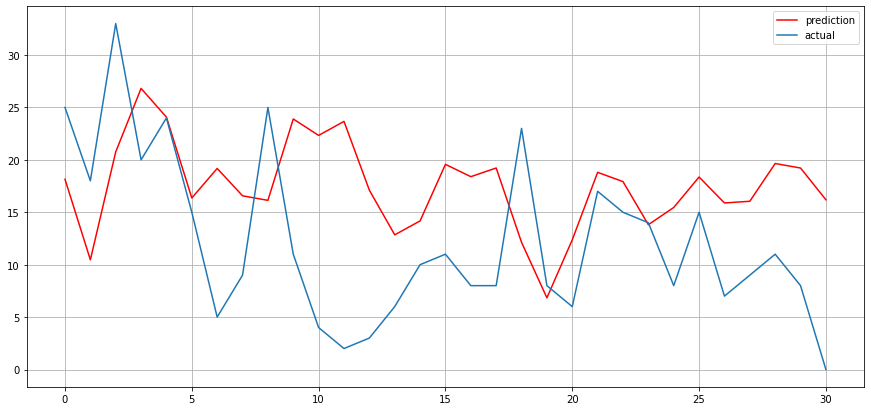

In [31]:
plt.figure(figsize=(15, 7))
plt.plot(pred, "r", label="prediction")
plt.plot(y_valid.values, label="actual")
plt.legend()
plt.grid(True);

## 3. Вывод

Модель не идеально справляется с предсказаниями на валидационной выборке.

Такие результаты могут быть получены по разным причинам:
- использовалась самая простая модель линейной регрессии
- не выполнялась серьезная предобработка данных
- такие параметры как количество лагов и размер окна скользящего среднего выбирались случайным образом и могут быть не самыми оптимальными

Для улучшения качества можно попробовать использовать модель SARIMA, но она требует трудоемкой подготовки данных, борьбы с нестационарностью ряда и подбора подходящих параметров.

Для получения предсказаний на тестовых данных произведем новое деление выборки с помощью ранее написанной функции

In [32]:
X_train, X_test, y_train = data_test_split(df, 7)

Обучим модель, сделаем предсказания, сохраним результаты в .csv файл в требуемом формате

In [33]:
model_test = LinearRegression()
model_test.fit(X_train, y_train)
pred_test = model_test.predict(X_test)

In [34]:
test['day_sales'] = pred_test
test['day_sales'] = test['day_sales'].apply(lambda x: int(x))
test = test.reset_index()
test.columns = ['dates', 'quantities']

In [35]:
test

,dates,quantities
0,2021-12-31,15
1,2022-01-01,12
2,2022-01-02,12
3,2022-01-03,10
4,2022-01-04,12
5,2022-01-05,11
6,2022-01-06,8


In [36]:
test.to_csv(r'C:\Users\leoci\Desktop\Leonid_tsivenko.csv', index=False)

**P.S.** Да, нигде и никак не учтено, что 31.12, 1.01, 2.01 это Новогодние дни и поведение покупателей сильно меняется, а 1.01 и вообще многие магазины не работают. Более того, мы не обладаем данными по этим же дням в прошлом году. Поэтому, скорее всего, прогноз на эти дни будет плохого качества.